# Fine-tune Amazon Titan Image Generator G1 provided by Amazon Bedrock

The code below will save the dataset below and create a folder called 'downloaded images' in your local directory.

In [2]:
# Import necessary libraries
import pandas as pd
import os
import requests
import json
import boto3
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import base64
import random

from PIL import Image

# Create the dataset into a dataframe using pandas
df = pd.read_csv('train.csv')

The function below will download an image to your local directory

In [ ]:
# Function to download an image to your local directory
def download_image(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an error on a bad status
        with open(save_path, 'wb') as file:
            file.write(response.content)
            # print(f"Image saved to {save_path}")
    except requests.RequestException as e:
        print(f"Failed to download {url}: {e}")



The code below will write all the image S3 URIs and their respectice image captions into our bedrock manifest file.

In [ ]:
# Create a bedrock manifest file to store the s3 uris and image captions
with open("bedrock_file.jsonl", 'w', encoding='utf-8') as output_file:
    
    # Array to store our caption and image data
    s3_uris = []
    captions = []
    folder_count = 0
    image_count = 0
    
    # Iterate through dataframe so we can save our image captions and S3 URI's
    for i, row in df.iterrows():
        image_id = row['id']
        filename = f"{image_id}.png"
        caption = row['caption']
        caption = caption[:500]
        image_ref = "INSERT S3 URI FILE PATH"
        info = {
            "image-ref": image_ref,
            "caption": caption
        }
        s3_uris.append(image_ref)
        captions.append(caption)
        save_dir = f"downloaded_images_{folder_count}"
        
        # Create a directory to store the images
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filename)

        # Downloadn the images
        download_image(row['image_url'], save_path)
        if image_count == 1000:
            folder_count += 1
            image_count = 0
            
        # Use 4000 images in the training set
        if i > 4000:
            break
        image_count += 1
        output_file.write(json.dumps(info) + "\n")

    # Confirm that all images have been downloaded to your directory folder
    print("Images have been downloaded from training set")

This code will resize images to valid dimensions and sizes so that it is acceptable for the fine-tuning job

In [ ]:
def resize_images(s3_image_locations, min_size=512, max_size=4096, aspect_ratio_limit=4):
    s3 = boto3.client('s3')

    for image_location in s3_image_locations:
        bucket_name, key = image_location.replace('s3://', '').split('/', 1)

        # Get the image from S3
        try:
            response = s3.get_object(Bucket=bucket_name, Key=key)
        except:
            # print(key)
            break
        image_data = response['Body'].read()
        # if key.split('.')[-1].lower() not in ['jpg','jpeg']:
        #     count += 1
        #     print(count)
            
        # Open the image using Pillow
        image = Image.open(io.BytesIO(image_data))
        width, height = image.size
        # print(image.size)
        #plt.imshow(image)
        #plt.show()
        
        if width < min_size:
            ratio = (1 - width / (1.*min_size))
            #print(ratio)
            image = image.resize((min_size, int(math.ceil((1+ratio)*height))), Image.LANCZOS)
            width, height = image.size
            #print(image.size)
        
        if height < min_size:
            ratio = (1 - height / (1.*min_size))
            #print(ratio)
            image = image.resize((int(math.ceil((1+ratio)*width)), min_size), Image.LANCZOS)
            width, height = image.size
            #print(image.size)

        if width > max_size or height > max_size:
            # Crop the image
            if width >= height:
                new_width = max_size
                new_height = int(height * (max_size / width))
            else:
                new_height = max_size
                new_width = int(width * (max_size / height))
            left = (width - new_width) // 2
            top = (height - new_height) // 2
            right = left + new_width
            bottom = top + new_height
            image = image.crop((left, top, right, bottom))
        
        # Check aspect ratio and crop if necessary
        aspect_ratio = max(width, height) / min(width, height)
        if aspect_ratio > aspect_ratio_limit:
            plt.imshow(image)
            plt.show()
            # Crop to maintain the aspect ratio limit
            if width > height:
                new_width = int(4*height) #int(height * aspect_ratio_limit)
                left = 0 #(width - new_width) // 2
                right = new_width-1 #left + new_width
                image = image.crop((left, 0, right, height))
            else:
                new_height = int(4*width) #int(width / aspect_ratio_limit)
                top = 0 #(height - new_height) // 2
                bottom = new_height #top + new_height
                image = image.crop((0, top, width, bottom))
            plt.imshow(image)
            plt.show()
    
        #plt.imshow(image)
        #plt.show()
        # print(image.size)
        # print()
        #continue
        # Save the modified image back to S3
        output_buffer = io.BytesIO()
        try:
            image.save(output_buffer, format='png')
        except:
            image = image.convert('RGB')
            image.save(output_buffer, format='png')
        #    print(key)
        #    plt.imshow(image)
        #    1/0
        output_buffer.seek(0)
        s3.put_object(Bucket=bucket_name, Key=key, Body=output_buffer)
        
# Resize all images
resize_images(s3_uris)
print("Image resizing and cropping completed.")

# Create a Model Customization Job

Here we will create a model customization job, so we can fine-tune it on our image dataset.

Amazon Titan Image Generator v2 customization hyperparameters: 
- `batchSize`: The number of samples processed before updating model parameters and can take up any integer values in the range of 8 and 192, with a default value of 8.
- `stepCount`: The number of times the model is exposed to each batch and can take any integer values in the range 10 - 40,000. 
- `learningRate`:	The rate at which model parameters are updated after each batch	which can take up a float value between 1.00E-7 and 1 with a default value set to	1.00E-5.

For guidelines on setting hyper-parameters refer to the guidelines provided [here](https://docs.aws.amazon.com/bedrock/latest/userguide/cm-hp-titan-image.html)

<div class="alert alert-block alert-info">
<b>Note:</b> Creating a model customization job will take around 30-60mins to complete.</div>

<div class="alert alert-block alert-info">
<b>Note:</b> Make sure all images from your dataset are uploaded to the appropiate S3 bucket before creating a Model Customization Job.</div>

In [ ]:
# Create Model Customization Job
client = boto3.client('bedrock')

# Set a name for the Job
job_name = 'INSERT NAME OF JOB'

# Set a name for the Custom Model
custom_model_name = 'INSERT NAME OF CUSTOM MODEL'

# Set a roleArn that will give you access S3 and Bedrock
role_arn = 'INSERT ROLE ARN'

# Set the Base Model for which you will be running the job on
base_model_identifier = 'amazon.titan-image-generator-v2:0'

# Set the customization type to "FINE_TUNING" or "CONTINUED_PRE_TRAINING"
customization_type = 'FINE_TUNING'

# input the S3 URI of where your Training Data is located
training_data = "INSERT S3 PATH TO TRAINING DATA"

# Set the output where you want the results to go
output_data = "INSERT S3 PATH TO OUTPUT FOLDER"

# Set the Hyper parameters for the job
hyper_parameters = {
    'batchSize': '8',
    'stepCount': '10',
    'learningRate': '1.00E-5',
}

# # Create the customization job
response = client.create_model_customization_job(
    jobName=job_name,
    customModelName=custom_model_name,
    roleArn=role_arn,
    baseModelIdentifier=base_model_identifier,
    customizationType=customization_type,
    trainingDataConfig=training_data,
    outputDataConfig=output_data,
    hyperParameters=hyper_parameters
)

# Confirm the Job was created successfully
print("Creating Custom Model job!!!")

To confirm your model is created you can check the through the AWS Console, under the custom models section in the jobs tab.

# Overview of Provisioned throughput
You specify Provisioned Throughput in Model Units (MU). A model unit delivers a specific throughput level for the specified model. The throughput level of a MU for a given Text model specifies the following:

    - The total number of input tokens per minute – The number of input tokens that an MU can process across all requests within a span of one minute.

    - The total number of output tokens per minute – The number of output tokens that an MU can generate across all requests within a span of one minute.

Model unit quotas depend on the level of commitment you specify for the Provisioned Throughput.

    - For custom models with no commitment, a quota of one model unit is available for each Provisioned Throughput. You can create up to two Provisioned Throughputs per account.

    - For base or custom models with commitment, there is a default quota of 0 model units. To request an increase, use the limit increase form.

# Provision Throughput to the model

<div class="alert alert-block alert-info">
<b>Note:</b> Creating provisioned throughput will take around 20-30mins to complete.</div>

You will need to create provisioned throughput to be able to evaluate the model performance. 

In [ ]:
# Set model units you want provisioned
model_units = 1

# Input the name of the model you want provisioned
provisioned_model_name = "INSERT NAME OF PROVISONED THROUGHPUT"

# Include the ID of the model that you want provisioned
model_id = 'INSERT CUSTOM MODEL ID"

response = client.create_provisioned_model_throughput(
    modelUnits=model_units,
    provisionedModelName=provisioned_model_name,
    modelId=model_id
)

print("Provisioned Model Throughput")

# Invoke the provisioned Custom Model and generate images

<div class="alert alert-block alert-info">
<b>Note:</b> Please make sure your provisioned throughput job status becomes InService before proceeding. </div>

prompt: 'a trading card version of Charizard, Fire Type, 150 HP'


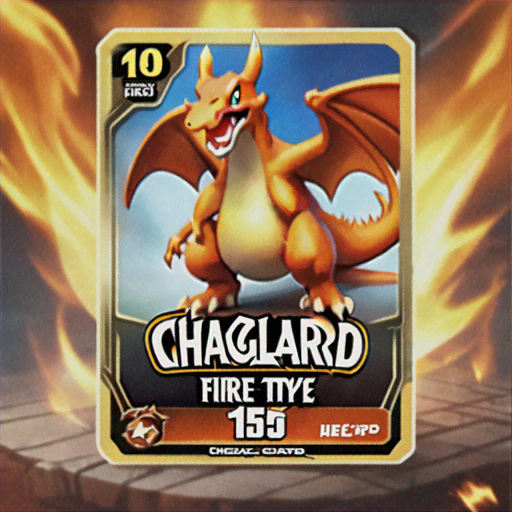

In [3]:
# Create a Bedrock Runtime client in the AWS Region of your choice.
client = boto3.client("bedrock-runtime", region_name="us-east-1")

# Set the model ID, e.g., Titan Image Generator G1.
model_id = 'INSERT PROVISIONED MODEL ID"

# Generate a random seed.
seed = random.randint(0, 2147483647)

prompt = "a trading card version of Charizard, Fire Type, 150 HP"
# Format the request payload using the model's native structure.
native_request = {
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {"text": prompt},
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "standard",
        "cfgScale": 8.0,
        "height": 512,
        "width": 512,
        "seed": seed,
    },
}

# Convert the native request to JSON.
request = json.dumps(native_request)

# Invoke the model with the request.
response = client.invoke_model(modelId=model_id, body=request)

# Decode the response body.
model_response = json.loads(response["body"].read())

# Extract the image data.
base64_image_data = model_response["images"][0]

image_data = base64.b64decode(base64_image_data)

image = Image.open(io.BytesIO(image_data))
print(f"prompt: '{prompt}'")
image.show()

Now, we are going to generate another example

prompt: 'a trading card version of pikachu, electric type, 100 HP'


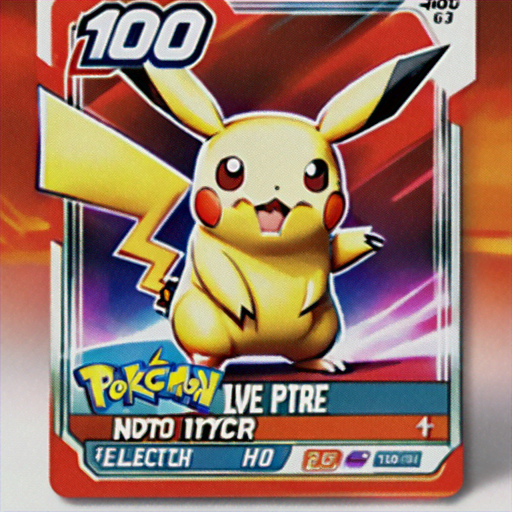

In [4]:
# Format the request payload using the model's native structure.
prompt = "a trading card version of pikachu, electric type, 100 HP"

seed = random.randint(0, 2147483647)

native_request = {
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {"text": prompt},
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "standard",
        "cfgScale": 8.0,
        "height": 512,
        "width": 512,
        "seed": seed,
    },
}

# Convert the native request to JSON.
request = json.dumps(native_request)

# Invoke the model with the request.
response = client.invoke_model(modelId=model_id, body=request)

# Decode the response body.
model_response = json.loads(response["body"].read())

# Extract the image data.
base64_image_data = model_response["images"][0]

image_data = base64.b64decode(base64_image_data)

image = Image.open(io.BytesIO(image_data))
print(f"prompt: '{prompt}'")
image.show()

Now, we are going to generate example #3

prompt: 'a new trading card version of ditto, water type, 70 HP'


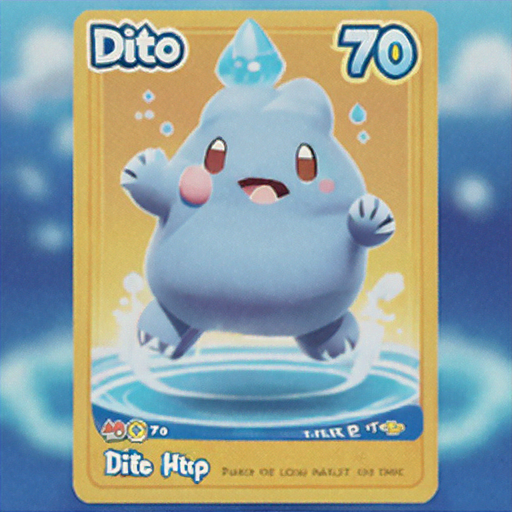

In [5]:
# Format the request payload using the model's native structure.
prompt = "a new trading card version of ditto, water type, 70 HP"

seed = random.randint(0, 2147483647)

native_request = {
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {"text": prompt},
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "standard",
        "cfgScale": 8.0,
        "height": 512,
        "width": 512,
        "seed": seed,
    },
}

# Convert the native request to JSON.
request = json.dumps(native_request)

# Invoke the model with the request.
response = client.invoke_model(modelId=model_id, body=request)

# Decode the response body.
model_response = json.loads(response["body"].read())

# Extract the image data.
base64_image_data = model_response["images"][0]

image_data = base64.b64decode(base64_image_data)

image = Image.open(io.BytesIO(image_data))
print(f"prompt: '{prompt}'")
image.show()

Now, we are going to do a custom example

prompt: 'a new trading card version of Andy, a male with brown hair, water type, 100 HP'


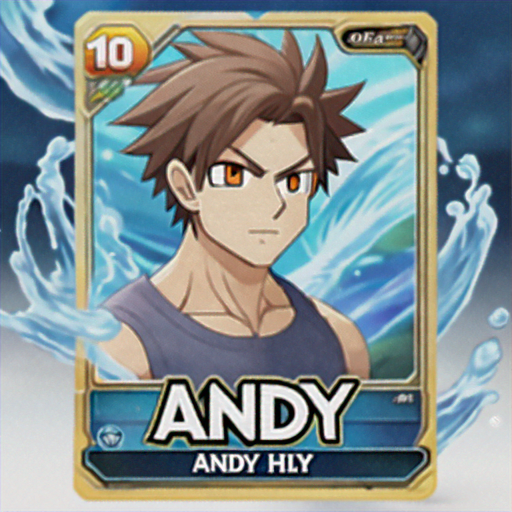

In [6]:
# Format the request payload using the model's native structure.
prompt = "a new trading card version of Andy, a male with brown hair, water type, 100 HP"

seed = random.randint(0, 2147483647)

native_request = {
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {"text": prompt},
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "standard",
        "cfgScale": 8.0,
        "height": 512,
        "width": 512,
        "seed": seed,
    },
}

# Convert the native request to JSON.
request = json.dumps(native_request)

# Invoke the model with the request.
response = client.invoke_model(modelId=model_id, body=request)

# Decode the response body.
model_response = json.loads(response["body"].read())

# Extract the image data.
base64_image_data = model_response["images"][0]

image_data = base64.b64decode(base64_image_data)

image = Image.open(io.BytesIO(image_data))
print(f"prompt: '{prompt}'")
image.show()

# Clean up the resources we provisioned

<div class="alert alert-block alert-warning">
<b>Warning:</b> Please make sure to delete providsioned throughput with the following code as there will be cost incurred if its left in running state, even if you are not using it. 
</div>

In [ ]:
# delete the provisioned throughput
client = boto3.client('bedrock')

model_id = "INSERT PROVISIONED MODEL ID"
response = client.delete_provisioned_model_throughput(
    provisionedModelId=model_id
)
print("Deleting Provisioned Model Throughput")